In [4]:
import os
import glob
import re
from typing import Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud

In [5]:
FOLDER_MINUTES_TXT = "./data/processed/copom_minutes_processed" 

In [6]:
def download_nltk_resources():
    
    try:
        nltk.data.find('tokenizers/punkt_tab')
    except LookupError:
        nltk.download('punkt_tab', quiet=True)

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords', quiet=True)

    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet', quiet=True)

    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger', quiet=True)

    try:
        nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    except LookupError:
        nltk.download('averaged_perceptron_tagger_eng', quiet=True)


download_nltk_resources()

In [7]:
def analyze_text(text: str) -> Dict[str, Any]:
    lower_text = text.lower()
    text_wo_punctuation = re.sub(r'[^\w\s]', '', lower_text)
    tokens = text_wo_punctuation.split()


    word_count = len(tokens)
    

    paragraphs = [p for p in text.split('\n\n') if p.strip()]
    paragraph_count = len(paragraphs)
    

    if word_count == 0:
        lexical_diversity = 0
    else:
        unique_words = len(set(tokens))
        lexical_diversity = unique_words / word_count
        
        
    return {
        "word_count": word_count,
        "paragraph_count": paragraph_count,
        "lexical_diversity": lexical_diversity
    }

In [8]:
filepaths = glob.glob(f"{FOLDER_MINUTES_TXT}/*.txt")

minutes_info = pd.read_excel("./data/raw/minutes_info.xlsx")
minutes_info['DataReferencia'] = pd.to_datetime(minutes_info['DataReferencia'])

In [9]:
all_minutes_data = []
full_corpus_text = []

for path in filepaths:
    filename = os.path.basename(path)

    # Getting date
    minutes_info_temp = minutes_info.copy()
    minutes_info_temp = minutes_info_temp[minutes_info_temp["Titulo"] == filename.replace(".txt", "")]
    date = minutes_info_temp["DataReferencia"].values[0]
    
    if date is None:
        continue
        
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read()
        full_corpus_text.append(text)
        
    metrics = analyze_text(text)
    
    all_minutes_data.append({
        "filename": filename,
        "date": date,
        **metrics
    })

In [10]:
df = pd.DataFrame(all_minutes_data)
df = df.sort_values(by='date').reset_index(drop=True)
df['year'] = df['date'].dt.year

In [11]:
print(df[['word_count', 'paragraph_count', 'lexical_diversity']].describe())

        word_count  paragraph_count  lexical_diversity
count   230.000000       230.000000         230.000000
mean   4596.165217        55.404348           0.254169
std    2480.454529        22.035838           0.049906
min     788.000000        14.000000           0.179741
25%    2213.250000        35.000000           0.205501
50%    4122.500000        59.000000           0.257707
75%    6713.500000        76.000000           0.283839
max    9363.000000        93.000000           0.394670


In [12]:
sns.set_theme(style="whitegrid", palette="viridis")

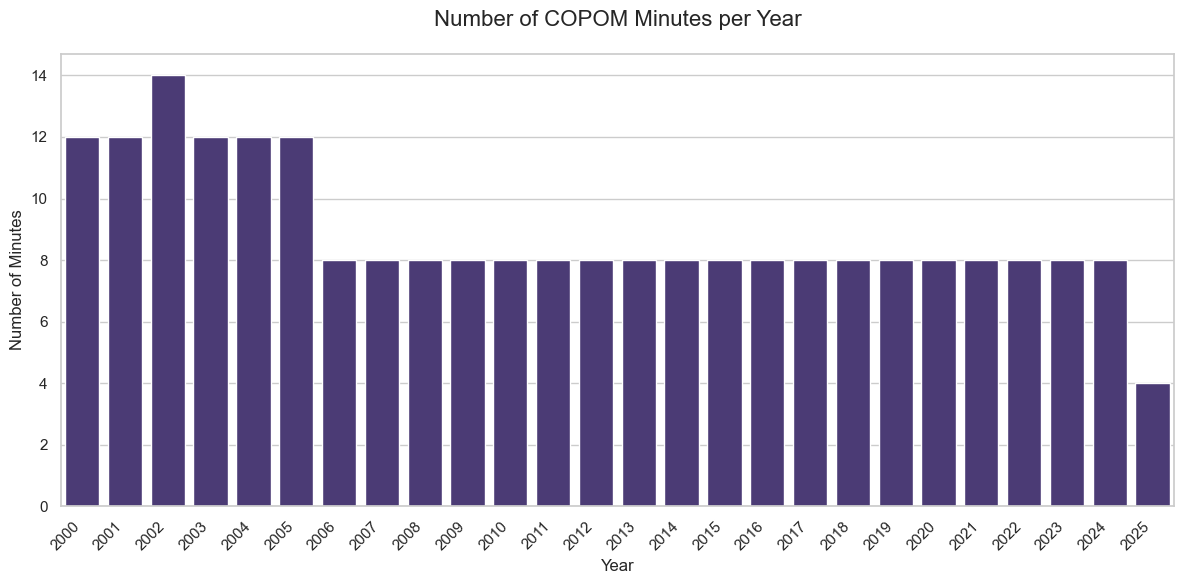

In [13]:
# 1° Graph: Number of Minutes per Year
plt.figure(figsize=(12, 6))
minutes_per_year = df.groupby('year').size()
sns.barplot(x=minutes_per_year.index, y=minutes_per_year.values)
plt.title('Number of COPOM Minutes per Year', fontsize=16, pad=20)
plt.xlabel('Year')
plt.ylabel('Number of Minutes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.close()

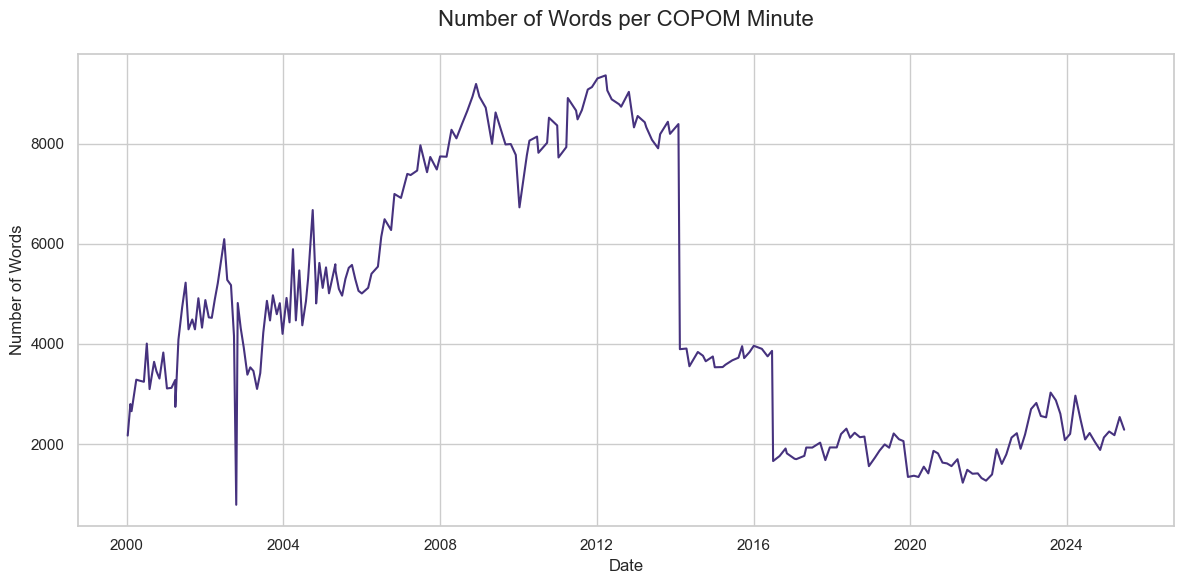

In [14]:
# 2° Graph: Number of Words per Minute
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='word_count')
plt.title('Number of Words per COPOM Minute', fontsize=16, pad=20)
plt.xlabel('Date')
plt.ylabel('Number of Words')
plt.tight_layout()
plt.show()

plt.close()

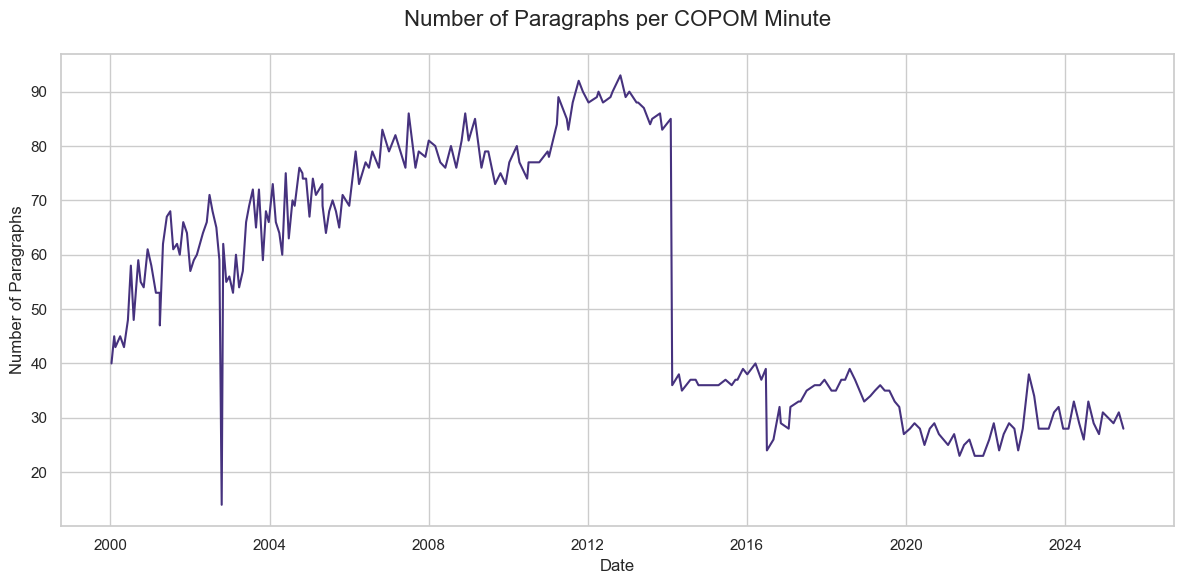

In [15]:
# 3° Graph: Number of Paragraphs per Minute
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='paragraph_count')
plt.title('Number of Paragraphs per COPOM Minute', fontsize=16, pad=20)
plt.xlabel('Date')
plt.ylabel('Number of Paragraphs')
plt.tight_layout()
plt.show()

plt.close()

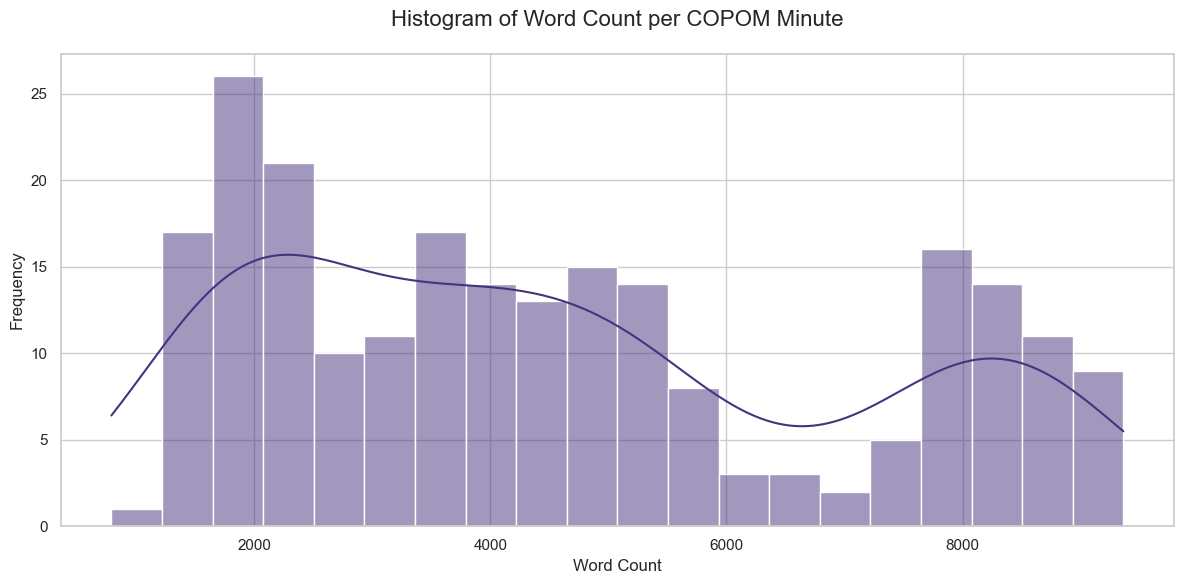

In [16]:
# 4° Graph: Histogram of Word Count per COPOM Minute
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], kde=True, bins=20)
plt.title('Histogram of Word Count per COPOM Minute', fontsize=16, pad=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.close()

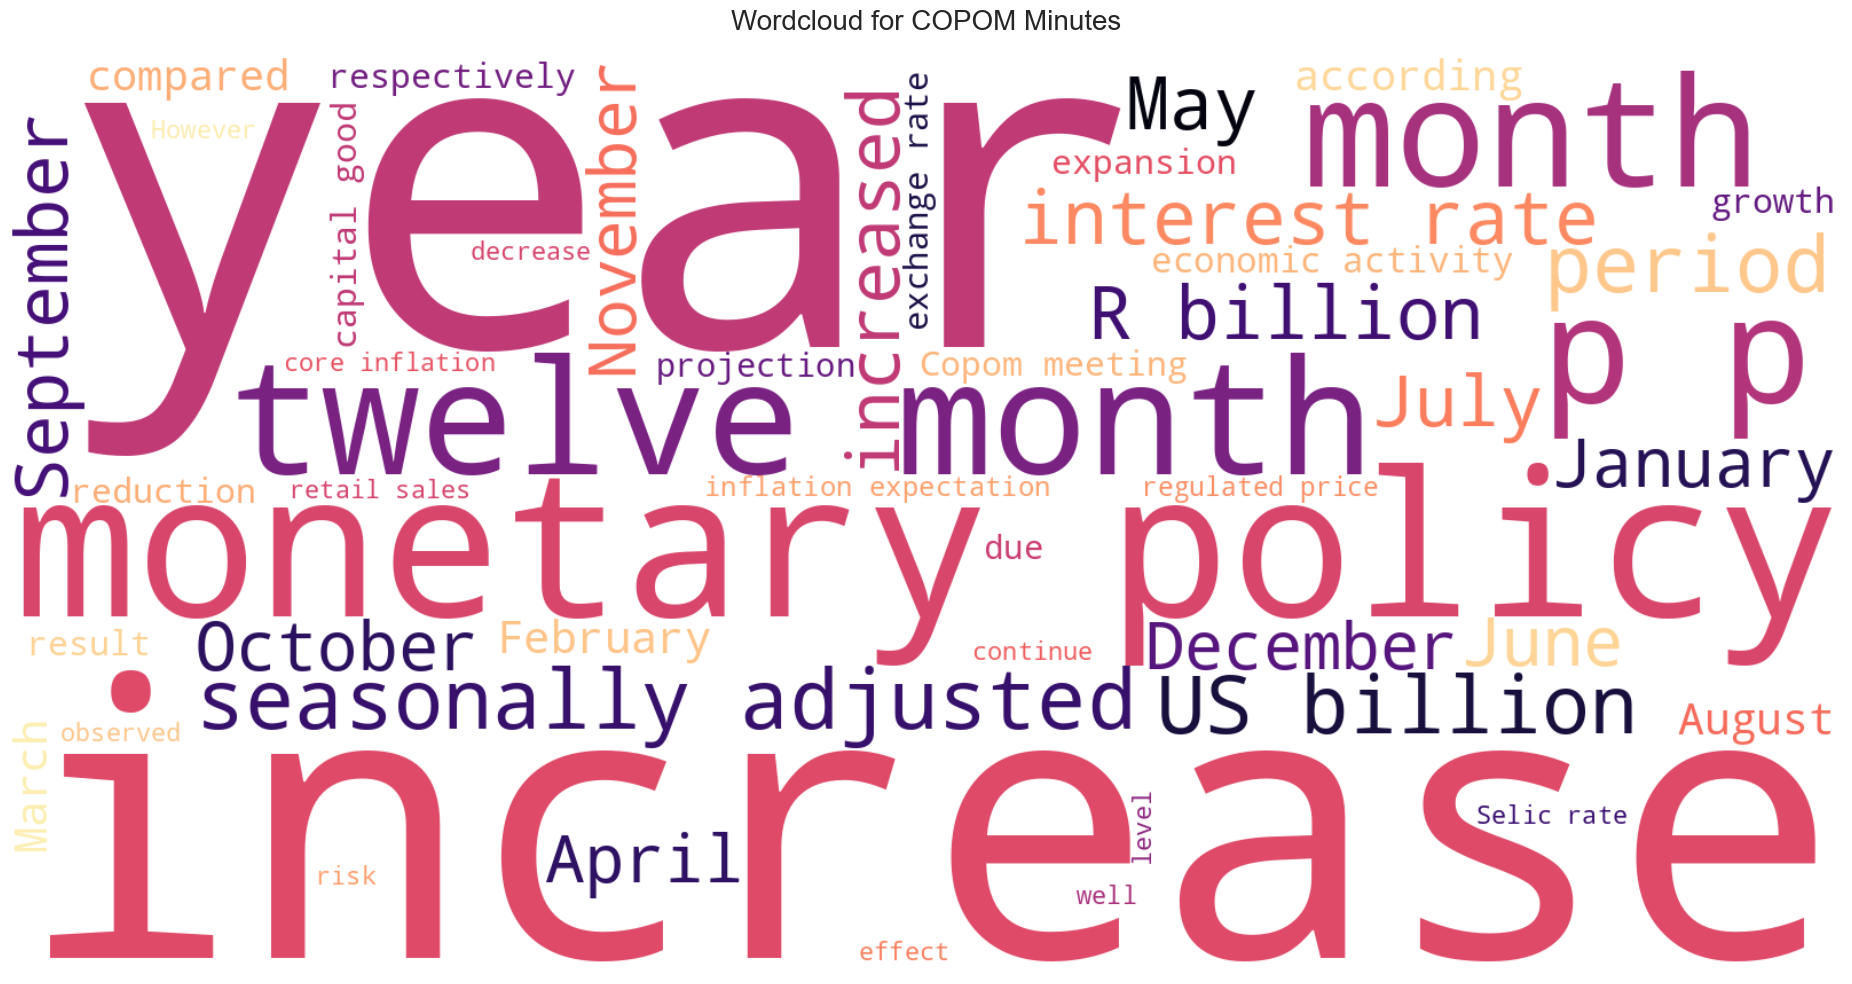

In [17]:
# 5° Graph: wordcloud
all_minutes_text = " ".join(full_corpus_text)
stopwords_set = set(stopwords.words('english'))

wordcloud = WordCloud(
    stopwords=stopwords_set, background_color="white", width=1600, height=800,
    max_words=50, colormap='magma'
).generate(all_minutes_text)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for COPOM Minutes', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

plt.close()